In [1]:
import anndata as ad
import torch
import pandas as pd
import requests
import sys
import os
import scanpy as sc
#import pertpy as pt      # comment-out when using nen_env
import re
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import json
import pickle
from scipy.stats import wasserstein_distance

from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())

sys.path.append('../src/null-effect-net')
sys.path.append('../src/external/PINNACLE')

from finetune_pinnacle import read_data
import utils            # comment-out when using pertpy_env

## Load SubCell embeddings

In [34]:
adata_subcell_embeddings = ad.read_h5ad('../data/subcell/all_features_harmonized_microscope_plate.h5ad')
adata_subcell_embeddings

AnnData object with n_obs × n_vars = 1138378 × 1536
    obs: 'cell_id', 'if_plate_id', 'position', 'sample', 'atlas_name', 'antibody', 'ensembl_ids', 'gene_names', 'locations', 'cell_path', 'Time (ms)', 'basename', 'image_width', 'well_id', 'well_id_num'

In [35]:
adata_subcell_embeddings.obs

,cell_id,if_plate_id,position,sample,atlas_name,antibody,ensembl_ids,gene_names,locations,cell_path,Time (ms),basename,image_width,well_id,well_id_num
0,1,1,A1,1,U2OS,HPA000992,ENSG00000066455,GOLGA5,Golgi apparatus,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.402596,1_A1_1_1,M1,1_A1,19918
1,2,1,A1,1,U2OS,HPA000992,ENSG00000066455,GOLGA5,Golgi apparatus,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.402596,1_A1_1_2,M1,1_A1,19918
2,3,1,A1,1,U2OS,HPA000992,ENSG00000066455,GOLGA5,Golgi apparatus,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.402596,1_A1_1_3,M1,1_A1,19918
3,4,1,A1,1,U2OS,HPA000992,ENSG00000066455,GOLGA5,Golgi apparatus,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.402596,1_A1_1_4,M1,1_A1,19918
4,5,1,A1,1,U2OS,HPA000992,ENSG00000066455,GOLGA5,Golgi apparatus,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.402596,1_A1_1_5,M1,1_A1,19918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138373,3,997,H1,6,A-431,HPA018805,ENSG00000075391,RASAL2,"Cytosol,Plasma membrane",/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.399605,997_H1_6_3,M2,997_H1,42447
1138374,4,997,H1,6,A-431,HPA018805,ENSG00000075391,RASAL2,"Cytosol,Plasma membrane",/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.399605,997_H1_6_4,M2,997_H1,42447
1138375,5,997,H1,6,A-431,HPA018805,ENSG00000075391,RASAL2,"Cytosol,Plasma membrane",/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.399605,997_H1_6_5,M2,997_H1,42447
1138376,6,997,H1,6,A-431,HPA018805,ENSG00000075391,RASAL2,"Cytosol,Plasma membrane",/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.399605,997_H1_6_6,M2,997_H1,42447


In [36]:
subcell_embeddings = {}

for ensembl_id in adata_subcell_embeddings.obs['ensembl_ids'].unique():

    indices = np.where(adata_subcell_embeddings.obs['ensembl_ids'].values == ensembl_id)[0]

    subcell_embeddings[ensembl_id] = adata_subcell_embeddings.X[indices, :].mean(axis=0)

subcell_embeddings

{'ENSG00000066455': array([ 0.6150107 , -0.29688028,  0.15005091, ..., -0.21737453,
        -0.22987524, -0.09332357], shape=(1536,), dtype=float32),
 'ENSG00000183092': array([ 0.35445264, -0.3043647 , -0.08126929, ..., -0.19405107,
         0.00181422,  0.04114043], shape=(1536,), dtype=float32),
 'ENSG00000102119': array([ 0.3801746 , -0.35846126,  0.01420267, ...,  0.02608456,
        -0.08170784,  0.04073204], shape=(1536,), dtype=float32),
 'ENSG00000113013': array([ 0.32732034, -0.23120669,  0.15015188, ..., -0.16009909,
        -0.08264957,  0.15368344], shape=(1536,), dtype=float32),
 'ENSG00000196611': array([ 0.29784113, -0.04201172,  0.23474173, ..., -0.38063154,
         0.00270949,  0.13621104], shape=(1536,), dtype=float32),
 'ENSG00000070669': array([ 0.39005885, -0.23263992,  0.25113863, ...,  0.07634787,
        -0.12303969,  0.05288054], shape=(1536,), dtype=float32),
 'ENSG00000100897': array([ 0.10279527, -0.3110163 ,  0.06223482, ..., -0.18988952,
        -0.00258

## Load ESM embeddings

In [37]:
esm_embeddings = torch.load('../data/esm/large_esm_uniprot_to_embedding_dictionary.pt')
esm_embeddings

{'A0A087X1C5': tensor([[ 5.2820e-02, -8.0160e-02, -4.7691e-02,  ..., -1.0234e-01,
           7.6881e-06,  3.7395e-02]]),
 'A0A0B4J2F0': tensor([[ 0.1344,  0.0060, -0.0433,  ..., -0.0817, -0.0435,  0.0807]]),
 'A0A0C5B5G6': tensor([[ 0.1117,  0.0429,  0.0842,  ...,  0.0832, -0.0452,  0.0277]]),
 'A0A0K2S4Q6': tensor([[-0.0131, -0.0035, -0.1262,  ..., -0.1361,  0.0905,  0.0204]]),
 'A0A0U1RRE5': tensor([[ 0.0573, -0.0211,  0.0156,  ...,  0.0259, -0.0512,  0.0641]]),
 'A0A1B0GTW7': tensor([[ 0.0325, -0.1093,  0.0236,  ..., -0.1064, -0.0333, -0.0307]]),
 'A0A8I5KW96': tensor([[-0.0462, -0.0566, -0.1008,  ..., -0.1053,  0.0383,  0.1263]]),
 'A0AV02': tensor([[ 0.0446, -0.0302,  0.0191,  ..., -0.0832, -0.0274,  0.0711]]),
 'A0AVF1': tensor([[ 0.0124,  0.0071,  0.0120,  ..., -0.0020, -0.0133,  0.1396]]),
 'A0AVI4': tensor([[ 0.0242,  0.0037,  0.0296,  ..., -0.1000, -0.0083,  0.0792]]),
 'A0AVK6': tensor([[ 0.0325, -0.0965,  0.0439,  ..., -0.1208,  0.0686,  0.0714]]),
 'A0AVT1': tensor([[ 0.03

In [38]:
for key, val in esm_embeddings.items():
    val = val[0]
    esm_embeddings[key] = val

esm_embeddings

{'A0A087X1C5': tensor([ 5.2820e-02, -8.0160e-02, -4.7691e-02,  ..., -1.0234e-01,
          7.6881e-06,  3.7395e-02]),
 'A0A0B4J2F0': tensor([ 0.1344,  0.0060, -0.0433,  ..., -0.0817, -0.0435,  0.0807]),
 'A0A0C5B5G6': tensor([ 0.1117,  0.0429,  0.0842,  ...,  0.0832, -0.0452,  0.0277]),
 'A0A0K2S4Q6': tensor([-0.0131, -0.0035, -0.1262,  ..., -0.1361,  0.0905,  0.0204]),
 'A0A0U1RRE5': tensor([ 0.0573, -0.0211,  0.0156,  ...,  0.0259, -0.0512,  0.0641]),
 'A0A1B0GTW7': tensor([ 0.0325, -0.1093,  0.0236,  ..., -0.1064, -0.0333, -0.0307]),
 'A0A8I5KW96': tensor([-0.0462, -0.0566, -0.1008,  ..., -0.1053,  0.0383,  0.1263]),
 'A0AV02': tensor([ 0.0446, -0.0302,  0.0191,  ..., -0.0832, -0.0274,  0.0711]),
 'A0AVF1': tensor([ 0.0124,  0.0071,  0.0120,  ..., -0.0020, -0.0133,  0.1396]),
 'A0AVI4': tensor([ 0.0242,  0.0037,  0.0296,  ..., -0.1000, -0.0083,  0.0792]),
 'A0AVK6': tensor([ 0.0325, -0.0965,  0.0439,  ..., -0.1208,  0.0686,  0.0714]),
 'A0AVT1': tensor([ 0.0390, -0.0462,  0.0109,  .

## Load Pinnacle embeddings

In [2]:
pinnacle_path = '../data/pinnacle_embeds'

pinnacle_embeddings = torch.load(os.path.join(pinnacle_path, 'pinnacle_protein_embed.pth'))

with open(os.path.join(pinnacle_path, 'pinnacle_protein_labels_dict.txt'), 'r') as f:
    labels_dict = f.read()
labels_dict = labels_dict.replace("\'", "\"")
labels_dict = json.loads(labels_dict)
celltypes = [c for c in labels_dict["Cell Type"] if c.startswith("CCI")]
celltype_dict = {ct.split("CCI_")[1]: i for i, ct in enumerate(celltypes)}
assert len(celltype_dict) > 0

protein_names = []
protein_celltypes = []
for c, p in zip(labels_dict["Cell Type"], labels_dict["Name"]):
    if c.startswith("BTO") or c.startswith("CCI") or c.startswith("Sanity"): continue
    protein_names.append(p)
    protein_celltypes.append(c)

proteins = pd.DataFrame.from_dict({"target": protein_names, "cell type": protein_celltypes})
celltype_protein_dict = proteins.pivot_table(values="target", index="cell type", aggfunc={"target": list}).to_dict()["target"]
assert len(celltype_protein_dict) > 0

In [28]:
celltypes = []
embeddings = []
proteins = []

for i, (key, prots) in enumerate(celltype_protein_dict.items()):

    for ii, prot in enumerate(prots):
        celltypes.append(key)
        proteins.append(prot)
        embeddings.append(pinnacle_embeddings[i][ii])

pinnacle_embed_df = pd.DataFrame({'Cell Type': celltypes, 'Protein': proteins, 'Embedding': embeddings})
pinnacle_embed_df['Embedding'] = pinnacle_embed_df['Embedding'].map(lambda tensor_list: [x.item() for x in tensor_list])
pinnacle_embed_df

,Cell Type,Protein,Embedding
0,acinar cell of salivary gland,SSR2,"[-0.01837669499218464, -0.005372554995119572, ..."
1,acinar cell of salivary gland,YAP1,"[-0.021167200058698654, -0.004439528565853834,..."
2,acinar cell of salivary gland,ERG28,"[-0.02101959101855755, -0.004643104039132595, ..."
3,acinar cell of salivary gland,CMTM4,"[-0.030215075239539146, -0.003957822918891907,..."
4,acinar cell of salivary gland,DOLK,"[-0.019849633798003197, -0.0048325867392122746..."
...,...,...,...
394755,vein endothelial cell,DHX33,"[-0.005831677932292223, -0.0002107618638547137..."
394756,vein endothelial cell,RHOA,"[-0.005097195506095886, -0.0002564966853242367..."
394757,vein endothelial cell,ALDH1A2,"[-0.008638364262878895, -0.0002583090390544384..."
394758,vein endothelial cell,CDKN1A,"[-0.006035568658262491, -0.0002095192321576178..."


In [30]:
average_pinnacle_embeddings = pinnacle_embed_df.groupby('Protein')['Embedding'].apply(
    lambda embeddings: np.mean(np.vstack(embeddings), axis=0)
).reset_index()
average_pinnacle_embeddings

,Protein,Embedding
0,A1BG,"[-0.003997962584253401, -0.003233219016692601,..."
1,A1CF,"[0.0352044838340953, 0.022495252662338316, -0...."
2,A2M,"[0.01617532517817846, 0.01922793447569305, 0.0..."
3,A4GALT,"[0.03718677135453618, 0.02352061587240314, 0.0..."
4,AACS,"[0.024479789931420883, 0.02704963330324972, 0...."
...,...,...
13638,ZXDB,"[-0.0045742428046651185, -0.003807972949289251..."
13639,ZXDC,"[0.01772096328822954, -0.004830996474629501, 0..."
13640,ZYG11B,"[0.018826813721003616, 0.029752710986873057, 0..."
13641,ZYX,"[0.001257244143441009, -0.0053505160688598384,..."


## Unify IDs

In [31]:
gene_ref = pd.read_csv('../data/id_mappings/gene_ref.tsv', sep='\t')
gene_ref

,HGNC ID,Approved symbol,Approved name,Status,Previous symbols,Alias symbols,Chromosome,Accession numbers,RefSeq IDs,NCBI Gene ID,Ensembl gene ID,Mouse genome database ID,Pubmed IDs,Alias names
0,HGNC:5,A1BG,alpha-1-B glycoprotein,Approved,NaN,NaN,19q13.43,NaN,NM_130786,1.0,ENSG00000121410,MGI:2152878,2591067,NaN
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,Approved,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569,19q13.43,BC040926,NR_015380,503538.0,ENSG00000268895,NaN,NaN,NaN
2,HGNC:24086,A1CF,APOBEC1 complementation factor,Approved,NaN,"ACF, ASP, ACF64, ACF65, APOBEC1CF",10q11.23,AF271790,NM_014576,29974.0,ENSG00000148584,MGI:1917115,"11815617, 11072063",NaN
3,HGNC:6,A1S9T,"symbol withdrawn, see [HGNC:12469](/data/gene-...",Symbol Withdrawn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HGNC:7,A2M,alpha-2-macroglobulin,Approved,NaN,"FWP007, S863-7, CPAMD5",12p13.31,"BX647329, X68728, M11313",NM_000014,2.0,ENSG00000175899,MGI:2449119,"2408344, 9697696",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49354,HGNC:25820,ZYG11B,"zyg-11 family member B, cell cycle regulator",Approved,ZYG11,FLJ13456,1p32.3,AB051517,NM_024646,79699.0,ENSG00000162378,MGI:2685277,11214970,NaN
49355,HGNC:13200,ZYX,zyxin,Approved,NaN,NaN,7q34,X95735,NM_003461,7791.0,ENSG00000159840,MGI:103072,"8917469, 8940160",NaN
49356,HGNC:51695,ZYXP1,zyxin pseudogene 1,Approved,NaN,NaN,8q24.23,NaN,NaN,NaN,ENSG00000274572,NaN,NaN,NaN
49357,HGNC:29027,ZZEF1,zinc finger ZZ-type and EF-hand domain contain...,Approved,NaN,"KIAA0399, ZZZ4, FLJ10821",17p13.2,BC035319,NM_015113,23140.0,ENSG00000074755,MGI:2444286,9455477,NaN


In [32]:
idmapping_file = '../data/id_mappings/HUMAN_9606_idmapping.dat'
uni_to_ensembl_mapping = utils.parse_uniprot_dat(idmapping_file)

for key, val_list in uni_to_ensembl_mapping.items():
    new_val_list = []
    for val in val_list:
        new_val_list.append(val[:val.find('.')])
    uni_to_ensembl_mapping[key] = new_val_list
uni_to_ensembl_mapping

{'P31946': ['ENSG00000166913'],
 'P62258': ['ENSG00000108953', 'ENSG00000274474'],
 'Q04917': ['ENSG00000128245'],
 'P61981': ['ENSG00000170027'],
 'P31947': ['ENSG00000175793'],
 'P27348': ['ENSG00000134308'],
 'P63104': ['ENSG00000164924'],
 'Q96QU6': ['ENSG00000110455'],
 'Q4AC99': ['ENSG00000205126'],
 'Q15172': ['ENSG00000066027'],
 'Q15173': ['ENSG00000068971'],
 'Q14738': ['ENSG00000112640'],
 'Q16537': ['ENSG00000154001'],
 'Q13362': ['ENSG00000078304'],
 'P30153': ['ENSG00000105568'],
 'P30154': ['ENSG00000137713'],
 'P63151': ['ENSG00000221914'],
 'Q00005': ['ENSG00000156475'],
 'Q66LE6': ['ENSG00000175470'],
 'Q9Y2T4': ['ENSG00000074211'],
 'P14060': ['ENSG00000203857'],
 'P26439': ['ENSG00000203859'],
 'Q9H2F3': ['ENSG00000099377'],
 'Q9Y3L3': ['ENSG00000100092'],
 'P78314': ['ENSG00000087266'],
 'Q7L8J4': ['ENSG00000175137'],
 'O60239': ['ENSG00000131370'],
 'P46952': ['ENSG00000162882'],
 'P31937': ['ENSG00000106049'],
 'P29372': ['ENSG00000103152'],
 'Q13541': ['ENSG0000

In [39]:
new_esm_embeddings = {}
for key, val in esm_embeddings.items():
    ensembl_id = uni_to_ensembl_mapping[key]
    if len(ensembl_id) > 0:
        ensembl_id = ensembl_id[0] # might need changing
        new_esm_embeddings[ensembl_id] = val
    else:
        print(f'Key {key} not found')

esm_embeddings = new_esm_embeddings
print(len(esm_embeddings))

Key A0A087X1C5 not found
Key A0A0C5B5G6 not found
Key A0M8Q6 not found
Key A4D2B8 not found
Key A6NGU5 not found
Key A6PVC2 not found
Key A9YTQ3 not found
Key B0L3A2 not found
Key C4AMC7 not found
Key G2XKQ0 not found
Key O00370 not found
Key O15197 not found
Key O43930 not found
Key O75343 not found
Key P00736 not found
Key P01834 not found
Key P01848 not found
Key P01850 not found
Key P01860 not found
Key P01880 not found
Key P01893 not found
Key P02746 not found
Key P04280 not found
Key P08842 not found
Key P0CG04 not found
Key P0DJD4 not found
Key P0DTU3 not found
Key P0DTU4 not found
Key P10163 not found
Key P16442 not found
Key P20810 not found
Key P24928 not found
Key P26927 not found
Key P31995 not found
Key P36268 not found
Key P49335 not found
Key P54317 not found
Key P60008 not found
Key P60507 not found
Key P63128 not found
Key Q0D2H9 not found
Key Q0P5N6 not found
Key Q14397 not found
Key Q14568 not found
Key Q14863 not found
Key Q3KNS1 not found
Key Q3SXR2 not found
Key Q

In [49]:
pinnacle_embeddings = {}

for i, row in average_pinnacle_embeddings.iterrows():
    subset = gene_ref[gene_ref['Approved symbol'] == row['Protein']]
    if len(subset) == 0:
        print(f"No match found for Protein {row['Protein']}")
        continue
    elif len(subset) == 1:
        ensembl_id = subset['Ensembl gene ID'].iloc[0]
        pinnacle_embeddings[ensembl_id] = row['Embedding']
    else:
        ensembl_id = subset['Ensembl gene ID'].iloc[0]
        pinnacle_embeddings[ensembl_id] = row['Embedding']
        print(f"Multiple matches found for Protein {row['Protein']}. Taking first match")

No match found for Protein ADAL
Multiple matches found for Protein APPL2. Taking first match
No match found for Protein ARNTL
No match found for Protein ARNTL2
No match found for Protein C10orf82
No match found for Protein C11orf1
No match found for Protein C11orf45
No match found for Protein C11orf49
No match found for Protein C12orf45
No match found for Protein C12orf65
No match found for Protein C12orf66
No match found for Protein C15orf65
No match found for Protein C16orf70
No match found for Protein C16orf72
No match found for Protein C17orf49
No match found for Protein C18orf25
No match found for Protein C19orf54
No match found for Protein C1orf109
No match found for Protein C1orf112
No match found for Protein C1orf131
No match found for Protein C1orf189
No match found for Protein C20orf27
No match found for Protein C20orf85
No match found for Protein C22orf46
No match found for Protein C2orf50
No match found for Protein C4orf19
No match found for Protein C4orf3
No match found fo

## Compile Embeddings into one dataframe

### Either only those where all Embeddings are available

In [89]:
shared_ensembl_ids = list(set(subcell_embeddings.keys()) & set(esm_embeddings.keys()) & set(pinnacle_embeddings.keys()))

df = pd.DataFrame()
df['Ensembl ID'] = shared_ensembl_ids
df['ESM Embedding'] = df['Ensembl ID'].map(esm_embeddings).apply(lambda x: x.tolist())
df['SubCell Embedding'] = df['Ensembl ID'].map(subcell_embeddings).apply(lambda x: x.tolist())
df['PINNACLE Embedding'] = df['Ensembl ID'].map(pinnacle_embeddings)
df

,Ensembl ID,ESM Embedding,SubCell Embedding,PINNACLE Embedding
0,ENSG00000167034,"[0.02055925503373146, 0.0038711787201464176, 0...","[0.2367967665195465, -0.23675759136676788, 0.2...","[0.016304028651512485, 0.02210188630952275, 0...."
1,ENSG00000166337,"[-0.03424886614084244, -0.13831709325313568, -...","[0.5734005570411682, -0.24030150473117828, 0.0...","[0.03417576992708236, 0.04639952942173894, 0.0..."
2,ENSG00000079134,"[0.009781671687960625, -0.006548859179019928, ...","[0.12326497584581375, -0.20264697074890137, 0....","[0.03695011963352426, 0.023213350980621463, -0..."
3,ENSG00000162222,"[0.025929881259799004, -0.00010180714161833748...","[0.2322436273097992, -0.278584748506546, 0.187...","[0.03084022584698687, 0.014901509438004723, 0...."
4,ENSG00000117036,"[-0.0014563289005309343, -0.10132259875535965,...","[0.17987316846847534, -0.2255319505929947, 0.0...","[-0.004793252376839518, -0.008850103849545122,..."
...,...,...,...,...
9304,ENSG00000073050,"[0.030647482722997665, -0.13844086229801178, -...","[0.23476684093475342, -0.10429483652114868, 0....","[0.03209838673846159, -0.004039019381468135, 0..."
9305,ENSG00000175691,"[-0.046901293098926544, 0.01375263649970293, 0...","[0.38430508971214294, -0.10721691697835922, 0....","[-0.006824458576738834, -0.0073191392351873216..."
9306,ENSG00000152056,"[0.03128628060221672, 0.11003908514976501, -0....","[0.43455880880355835, -0.16495060920715332, 0....","[0.05039560400715951, 0.0006223801028681919, 0..."
9307,ENSG00000182446,"[0.0621759332716465, -0.05273565649986267, 0.0...","[0.34176313877105713, -0.2554304599761963, 0.1...","[0.09650810080781044, 0.024206291134915056, 0...."


### Or all

In [90]:
# Get all unique Ensembl IDs
all_ensembl_ids = list(set(subcell_embeddings.keys()) | set(esm_embeddings.keys()) | set(pinnacle_embeddings.keys()))

# Create dataframe
df = pd.DataFrame()
df['Ensembl ID'] = all_ensembl_ids

# Function to safely convert elements to lists
def safe_to_list(x):
    if x is None:
        return None
    try:
        # Try to convert to list using tolist()
        return x.tolist()
    except AttributeError:
        # If tolist() doesn't exist, check if it's already a list
        if isinstance(x, list):
            return x
        # If it's a scalar or other type, wrap it in a list
        elif isinstance(x, (int, float, str, bool)):
            return [x]
        # For other types, try direct list conversion
        try:
            return list(x)
        except:
            # If all else fails, return None or the original element
            print(f"Warning: Could not convert {type(x)} to list")
            return None

# Apply the conversion with safe mapping
df['ESM Embedding'] = df['Ensembl ID'].map(lambda x: esm_embeddings.get(x)).apply(
    lambda x: safe_to_list(x) if x is not None else None
)

df['SubCell Embedding'] = df['Ensembl ID'].map(lambda x: subcell_embeddings.get(x)).apply(
    lambda x: safe_to_list(x) if x is not None else None
)

df['PINNACLE Embedding'] = df['Ensembl ID'].map(lambda x: pinnacle_embeddings.get(x)).apply(
    lambda x: safe_to_list(x) if x is not None else None
)

# Optional: Filter out rows with missing embeddings
# df = df.dropna(subset=['ESM Embedding', 'SubCell Embedding', 'PINNACLE Embedding'], how='all')

# Check the dataframe
print(f"Total entries: {len(df)}")
print(f"Entries with ESM embeddings: {df['ESM Embedding'].notna().sum()}")
print(f"Entries with SubCell embeddings: {df['SubCell Embedding'].notna().sum()}")
print(f"Entries with PINNACLE embeddings: {df['PINNACLE Embedding'].notna().sum()}")

Total entries: 20169
Entries with ESM embeddings: 19051
Entries with SubCell embeddings: 12502
Entries with PINNACLE embeddings: 13509


In [95]:
df

,Ensembl ID,ESM Embedding,SubCell Embedding,PINNACLE Embedding
0,ENSG00000166337,"[-0.03424886614084244, -0.13831709325313568, -...","[0.5734005570411682, -0.24030150473117828, 0.0...","[0.03417576992708236, 0.04639952942173894, 0.0..."
1,ENSG00000119915,"[-0.01778256893157959, -0.07960469275712967, -...","[0.22315159440040588, -0.23561878502368927, 0....",None
2,ENSG00000079134,"[0.009781671687960625, -0.006548859179019928, ...","[0.12326497584581375, -0.20264697074890137, 0....","[0.03695011963352426, 0.023213350980621463, -0..."
3,ENSG00000114790,"[0.04823337867856026, -0.03886687383055687, -0...","[0.27100566029548645, -0.23251645267009735, 0....",None
4,ENSG00000162222,"[0.025929881259799004, -0.00010180714161833748...","[0.2322436273097992, -0.278584748506546, 0.187...","[0.03084022584698687, 0.014901509438004723, 0...."
...,...,...,...,...
20164,ENSG00000148154,"[-0.004532282240688801, -0.045869164168834686,...",None,"[0.015610874686639622, -0.0042196777275031695,..."
20165,ENSG00000176723,"[0.13205578923225403, 0.06977512687444687, 0.0...","[0.1599438637495041, -0.2633529603481293, 0.10...",None
20166,ENSG00000019186,"[0.03196239098906517, -0.037445250898599625, -...","[0.2624763548374176, -0.3576650619506836, 0.30...",None
20167,ENSG00000284234,"[-0.019822202622890472, -0.04774238169193268, ...",None,None


## Scale Embeddings

### for only shared

In [91]:
def scale_embeddings(embedding_space):
    mean_norm = np.mean(np.linalg.norm(embedding_space, axis=1))
    return embedding_space / mean_norm

In [92]:
original_esm_embeddings = np.array([np.array(x) for x in df['ESM Embedding']])
original_subcell_embeddings = np.array([np.array(x) for x in df['SubCell Embedding']])
original_pinnacle_embeddings = np.array([np.array(x) for x in df['PINNACLE Embedding']])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (20169,) + inhomogeneous part.

In [94]:
scaled_esm = scale_embeddings(original_esm_embeddings)
scaled_subcell = scale_embeddings(original_subcell_embeddings)
scaled_pinnacle = scale_embeddings(original_pinnacle_embeddings)

TypeError: loop of ufunc does not support argument 13 of type NoneType which has no callable conjugate method

In [54]:
df['ESM Embedding'] = list([list(x) for x in scaled_esm])
df['SubCell Embedding'] = list([list(x) for x in scaled_subcell])
df['PINNACLE Embedding'] = list([list(x) for x in scaled_pinnacle])
df

,Ensembl ID,ESM Embedding,SubCell Embedding,PINNACLE Embedding
0,ENSG00000167034,"[0.0028145362823023164, 0.0005299595216486408,...","[0.002200696862015164, -0.0022003327834128417,...","[0.02840029120032928, 0.03849968745048708, 0.1..."
1,ENSG00000166337,"[-0.004688626909047148, -0.018935436949676598,...","[0.005328961307645572, -0.0022332685330640843,...","[0.05953141022201005, 0.08082420457555971, 0.1..."
2,ENSG00000079134,"[0.001339098611411978, -0.0008965306251028483,...","[0.001145576645861274, -0.0018833219692092947,...","[0.06436410165298277, 0.0404357684641299, -0.0..."
3,ENSG00000162222,"[0.0035497682908138604, -1.3937270266465224e-0...","[0.0021583817606795975, -0.00258905808071088, ...","[0.05372116385830175, 0.02595721685784264, 0.2..."
4,ENSG00000117036,"[-0.0001993696037519223, -0.013870936954973916...","[0.0016716711263733547, -0.002096006052993096,...","[-0.008349455598281492, -0.01541616074484265, ..."
...,...,...,...,...
9304,ENSG00000073050,"[0.004195602026609745, -0.01895238077701169, -...","[0.0021818315247462542, -0.0009692755641472429...","[0.055912777750702095, -0.007035643094679399, ..."
9305,ENSG00000175691,"[-0.006420728323922411, 0.0018827187241085425,...","[0.0035715817298381776, -0.0009964322411038444...","[-0.011887651512804947, -0.01274934496608555, ..."
9306,ENSG00000152056,"[0.004283052656760009, 0.015064213032876422, -...","[0.004038620209858725, -0.0015329866763180964,...","[0.08778504133007874, 0.0010841354941502634, 0..."
9307,ENSG00000182446,"[0.008511807445938149, -0.0072194453712633565,...","[0.0031762134175250005, -0.0023738711469537916...","[0.16810925843645932, 0.04216538941421464, 0.0..."


### Or for all

In [100]:
original_esm_embeddings = np.array([np.array(x) if x is not None else None for x in df['ESM Embedding']], dtype=object)
original_subcell_embeddings = np.array([np.array(x) if x is not None else None for x in df['SubCell Embedding']], dtype=object)
original_pinnacle_embeddings = np.array([np.array(x) if x is not None else None for x in df['PINNACLE Embedding']], dtype=object)

In [101]:
esm_none_indices = [i for i, x in enumerate(original_esm_embeddings) if x is None]
subcell_none_indices = [i for i, x in enumerate(original_subcell_embeddings) if x is None]
pinnacle_none_indices = [i for i, x in enumerate(original_pinnacle_embeddings) if x is None]

In [102]:
# Filter out None values for ESM embeddings
valid_esm_embeddings = [x for x in original_esm_embeddings if x is not None]
scaled_esm = scale_embeddings(valid_esm_embeddings)

# Filter out None values for subcell embeddings
valid_subcell_embeddings = [x for x in original_subcell_embeddings if x is not None]
scaled_subcell = scale_embeddings(valid_subcell_embeddings)

# Filter out None values for pinnacle embeddings
valid_pinnacle_embeddings = [x for x in original_pinnacle_embeddings if x is not None]
scaled_pinnacle = scale_embeddings(valid_pinnacle_embeddings)

In [103]:
# For ESM embeddings
scaled_esm_with_nones = []
valid_idx = 0
for i in range(len(original_esm_embeddings)):
    if i in esm_none_indices:
        scaled_esm_with_nones.append(None)
    else:
        scaled_esm_with_nones.append(list(scaled_esm[valid_idx]))
        valid_idx += 1

# For SubCell embeddings
scaled_subcell_with_nones = []
valid_idx = 0
for i in range(len(original_subcell_embeddings)):
    if i in subcell_none_indices:
        scaled_subcell_with_nones.append(None)
    else:
        scaled_subcell_with_nones.append(list(scaled_subcell[valid_idx]))
        valid_idx += 1

# For PINNACLE embeddings
scaled_pinnacle_with_nones = []
valid_idx = 0
for i in range(len(original_pinnacle_embeddings)):
    if i in pinnacle_none_indices:
        scaled_pinnacle_with_nones.append(None)
    else:
        scaled_pinnacle_with_nones.append(list(scaled_pinnacle[valid_idx]))
        valid_idx += 1

# Update the dataframe
df['ESM Embedding'] = scaled_esm_with_nones
df['SubCell Embedding'] = scaled_subcell_with_nones
df['PINNACLE Embedding'] = scaled_pinnacle_with_nones
df

,Ensembl ID,ESM Embedding,SubCell Embedding,PINNACLE Embedding
0,ENSG00000166337,"[-0.004711443175965689, -0.019027582473738106,...","[0.005328865883925698, -0.002233228542758544, ...","[0.05349628381011131, 0.07263047474561654, 0.1..."
1,ENSG00000119915,"[-0.002446258007470764, -0.010950814690421706,...","[0.002073846813962148, -0.0021897099500630835,...",None
2,ENSG00000079134,"[0.0013456150674962248, -0.000900893412426259,...","[0.0011455561324481265, -0.0018832882452661755...","[0.05783905061832015, 0.036336504338969504, -0..."
3,ENSG00000114790,"[0.0066352217879082735, -0.005346719121358694,...","[0.0025185758886447844, -0.002160878598511976,...",None
4,ENSG00000162222,"[0.0035670425296034517, -1.400509321008693e-05...","[0.0021583431113435213, -0.0025890117194147903...","[0.048275063830264656, 0.02332574744608275, 0...."
...,...,...,...,...
20164,ENSG00000148154,"[-0.0006234831292408587, -0.006309988763475903...",None,"[0.024436136612061152, -0.0066051789843900865,..."
20165,ENSG00000176723,"[0.01816624656905394, 0.009598611060957787, 0....","[0.0014864293178857145, -0.002447455951336346,...",None
20166,ENSG00000019186,"[0.0043969043615548495, -0.005151153649672058,...","[0.002439309267238588, -0.003323940172531657, ...",None
20167,ENSG00000284234,"[-0.0027268400914696473, -0.006567677817472780...",None,None


### Save it

In [55]:
df.to_csv('../data/embeddings.csv')

In [56]:
with open('../data/embeddings.pkl', 'wb') as f:
    pickle.dump(df, f)

## Look at known functional homologs

In [104]:
known_homologs = {
    'MAPK3_MAPK1':['ENSG00000102882', 'ENSG00000100030'], 
    'PRSS1_PRSS2': ['ENSG00000204983', 'ENSG00000275896'], 
    'MOB1A_MOB1B': ['ENSG00000114978', 'ENSG00000173542']
}

In [108]:
# Filter out rows with None values for each embedding type
esm_valid_indices = [i for i, x in enumerate(df['ESM Embedding']) if x is not None]
subcell_valid_indices = [i for i, x in enumerate(df['SubCell Embedding']) if x is not None]
pinnacle_valid_indices = [i for i, x in enumerate(df['PINNACLE Embedding']) if x is not None]

# Create filtered arrays for each embedding type
esm_embedding = np.array([df['ESM Embedding'][i] for i in esm_valid_indices])
subcell_embedding = np.array([df['SubCell Embedding'][i] for i in subcell_valid_indices])
pinnacle_embedding = np.array([df['PINNACLE Embedding'][i] for i in pinnacle_valid_indices])

# Create filtered arrays for Ensembl IDs
esm_ids = df['Ensembl ID'].values[esm_valid_indices]
subcell_ids = df['Ensembl ID'].values[subcell_valid_indices]
pinnacle_ids = df['Ensembl ID'].values[pinnacle_valid_indices]

# Create AnnData objects
adata_esm = ad.AnnData(X=esm_embedding)
adata_esm.obs_names = esm_ids
adata_esm.uns['embedding_type'] = 'ESM'

adata_subcell = ad.AnnData(X=subcell_embedding)
adata_subcell.obs_names = subcell_ids
adata_subcell.uns['embedding_type'] = 'SubCell'

adata_pinnacle = ad.AnnData(X=pinnacle_embedding)
adata_pinnacle.obs_names = pinnacle_ids
adata_pinnacle.uns['embedding_type'] = 'PINNACLE'

embedding_data = {
    'ESM': adata_esm,
    'SubCell': adata_subcell,
    'PINNACLE': adata_pinnacle
}

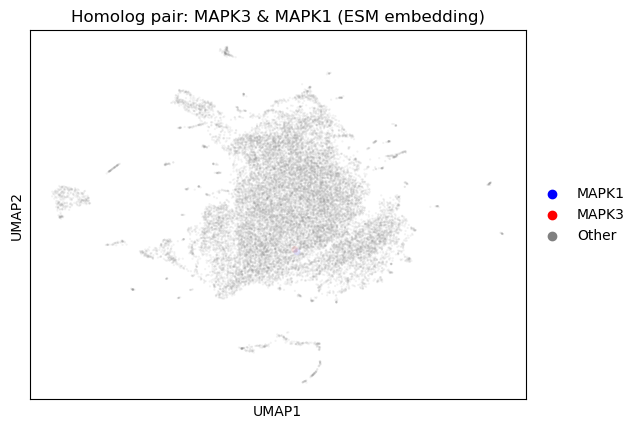

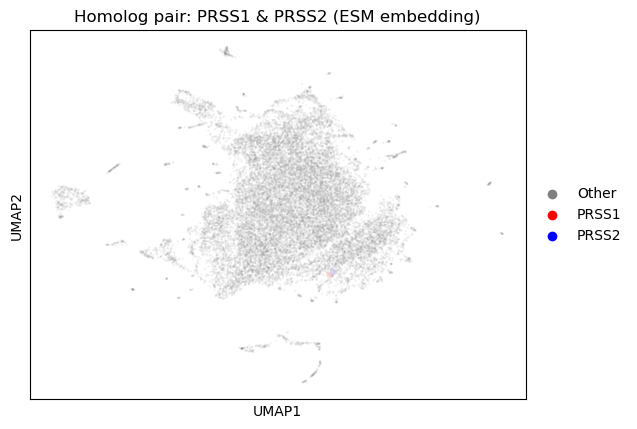

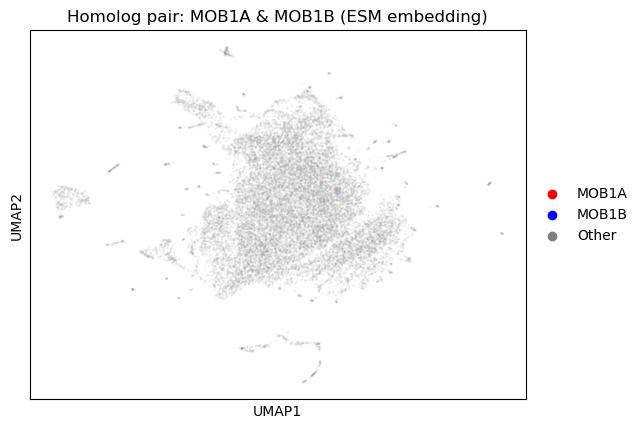

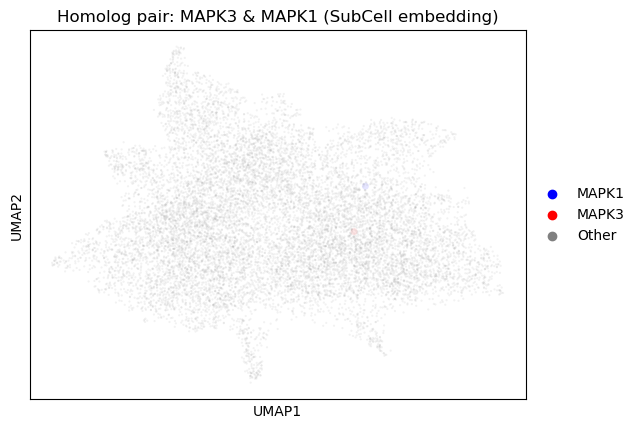

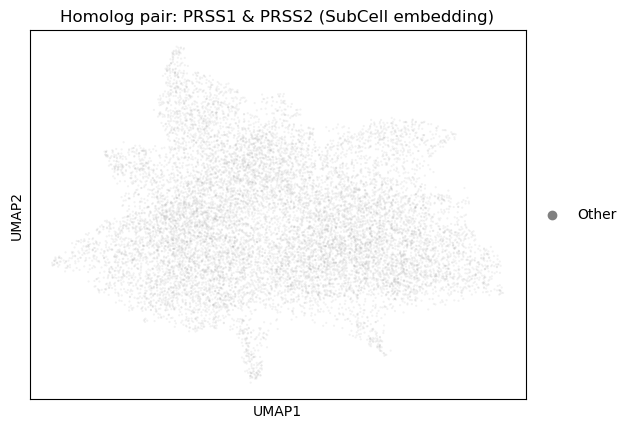

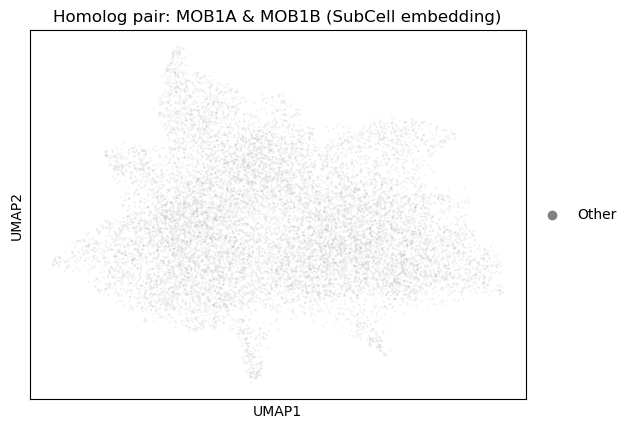

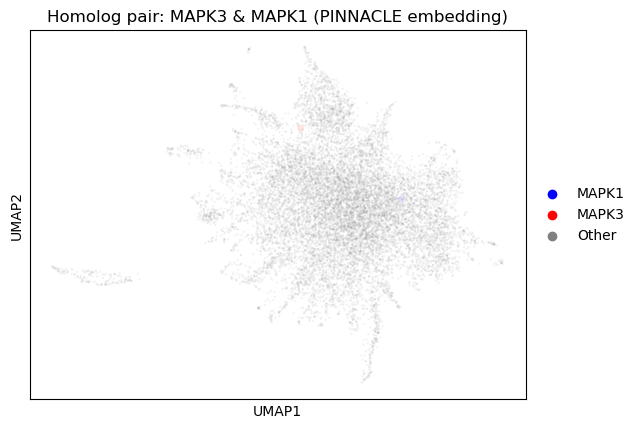

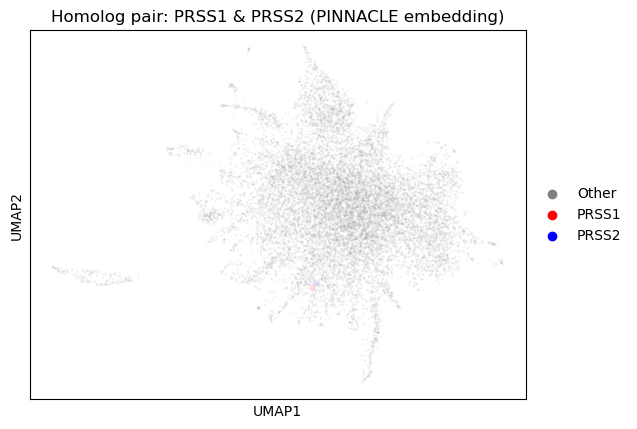

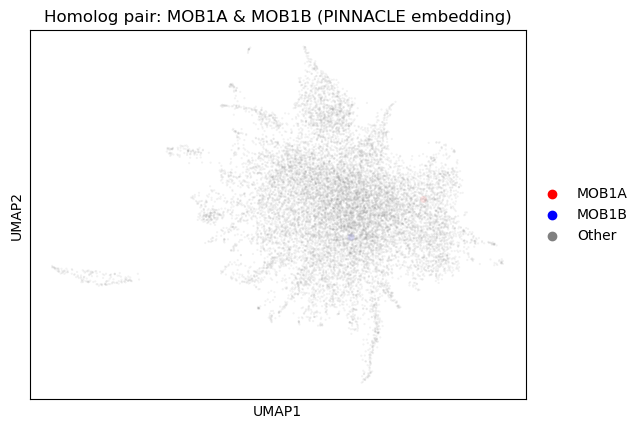

In [111]:
all_ensembl_ids = df['Ensembl ID'].values

for embedding in embedding_data.keys():
    adata = embedding_data[embedding]

    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

    for kh in known_homologs.keys():
        prot1 = kh[:kh.find('_')]
        prot2 = kh[kh.find('_')+1:]
        ensembl_id1 = known_homologs[kh][0]
        ensembl_id2 = known_homologs[kh][1]
        
        # Create a new categorical column in adata.obs to highlight the homologs
        adata.obs['homolog_highlight'] = 'Other'
        
        # Mark the specific homologs
        mask1 = adata.obs_names == ensembl_id1
        mask2 = adata.obs_names == ensembl_id2
        
        if any(mask1):
            adata.obs.loc[mask1, 'homolog_highlight'] = prot1
        if any(mask2):
            adata.obs.loc[mask2, 'homolog_highlight'] = prot2
            
        # Define a color palette for the new category
        color_palette = {'Other': 'gray', prot1: 'red', prot2: 'blue'}
        
        # Create point sizes
        point_sizes = np.where((adata.obs_names == ensembl_id1) | (adata.obs_names == ensembl_id2), 100, 10)
        
        # Create a new column for alpha values
        adata.obs['point_alpha'] = 0.1  # Default low alpha for background
        adata.obs.loc[adata.obs['homolog_highlight'].isin(['highlight1', 'highlight2']), 'point_alpha'] = 1.0

        # Plot with alpha values
        sc.pl.umap(adata, color='homolog_highlight', palette=color_palette, size=point_sizes,
                title=f"Homolog pair: {prot1} & {prot2} ({embedding} embedding)",
                alpha=adata.obs['point_alpha'])

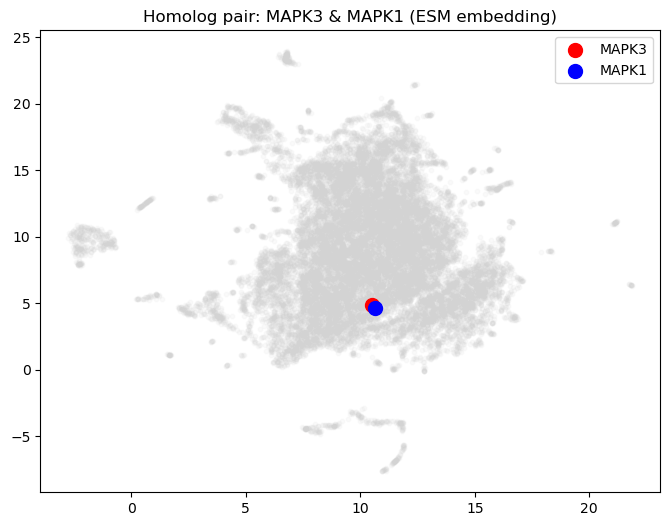

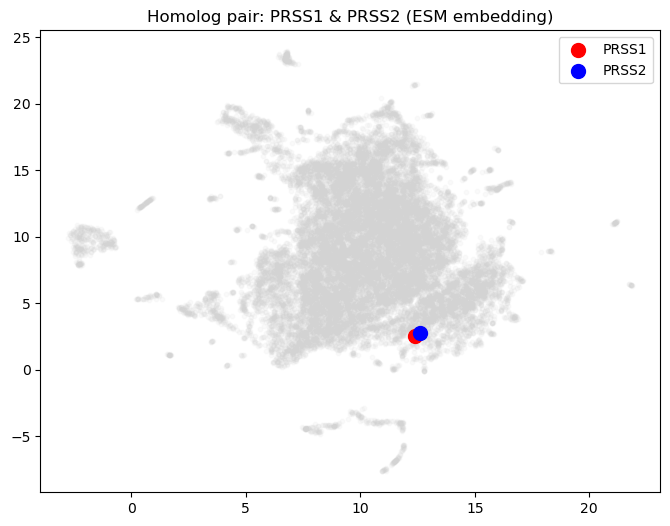

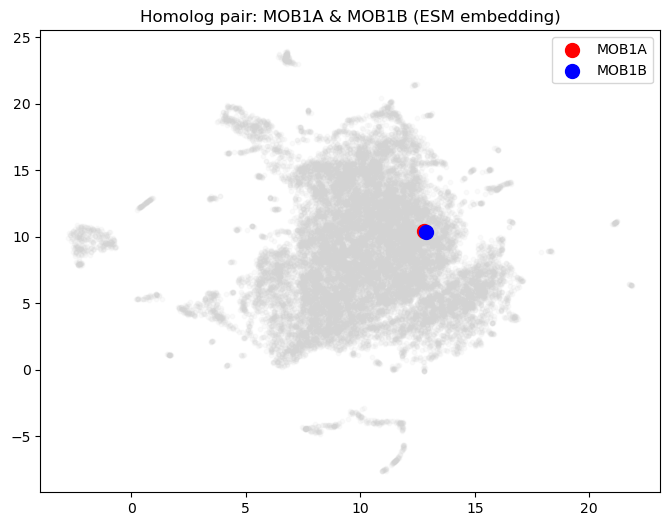

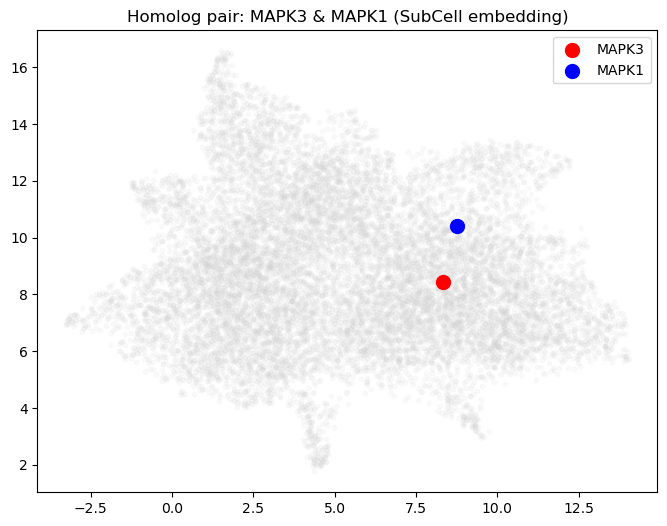

/tmp/ipykernel_62169/3771174920.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


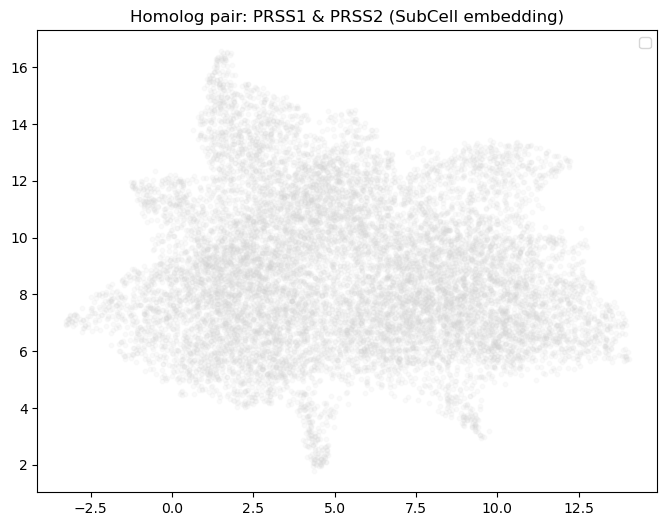

/tmp/ipykernel_62169/3771174920.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


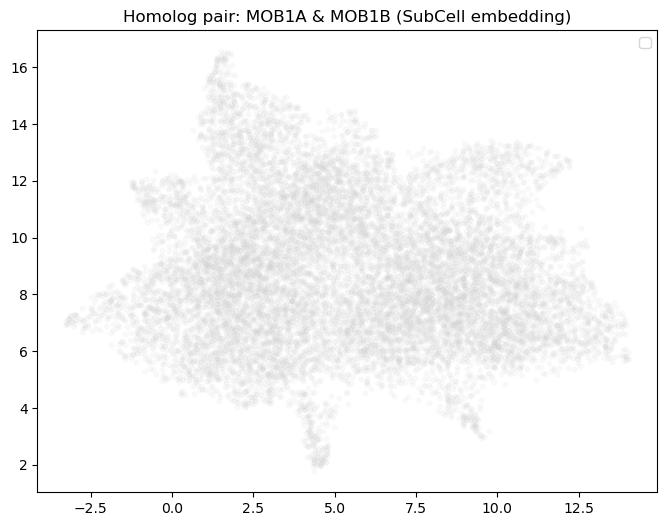

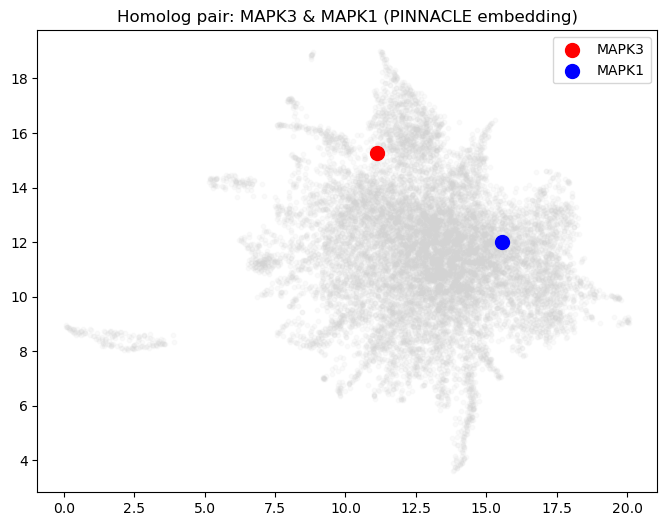

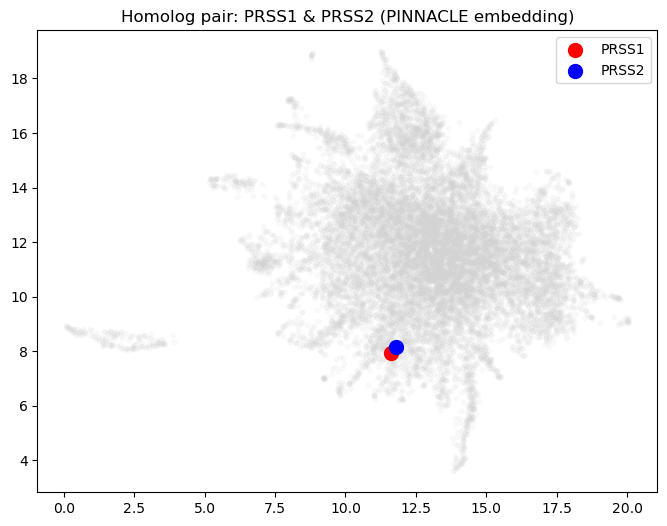

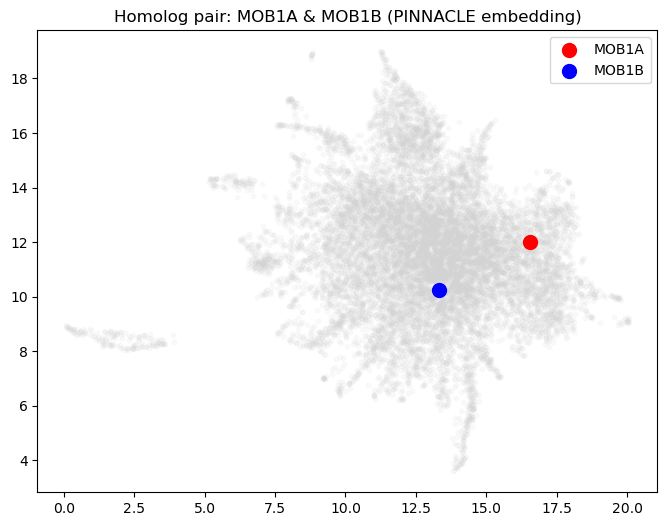

In [112]:
all_ensembl_ids = df['Ensembl ID'].values

for embedding in embedding_data.keys():
    adata = embedding_data[embedding]

    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

    for kh in known_homologs.keys():
        prot1 = kh[:kh.find('_')]
        prot2 = kh[kh.find('_')+1:]
        ensembl_id1 = known_homologs[kh][0]
        ensembl_id2 = known_homologs[kh][1]
        
        # Create a new categorical column in adata.obs to highlight the homologs
        adata.obs['homolog_highlight'] = 'Other'
        
        # Mark the specific homologs
        mask1 = adata.obs_names == ensembl_id1
        mask2 = adata.obs_names == ensembl_id2
        
        if any(mask1):
            adata.obs.loc[mask1, 'homolog_highlight'] = prot1
        if any(mask2):
            adata.obs.loc[mask2, 'homolog_highlight'] = prot2
            
        # Define a color palette for the new category
        color_palette = {'Other': 'lightgray', prot1: 'red', prot2: 'blue'}
        
        # Create point sizes based on whether they're highlights
        adata.obs['point_size'] = 10  # Default small size
        adata.obs.loc[adata.obs['homolog_highlight'].isin([prot1, prot2]), 'point_size'] = 100
        
        # Create alpha values
        adata.obs['point_alpha'] = 0.1  # Default low alpha for background
        adata.obs.loc[adata.obs['homolog_highlight'].isin([prot1, prot2]), 'point_alpha'] = 1.0

        # Plot in two steps for better control
        import matplotlib.pyplot as plt
        
        # Get UMAP coordinates
        umap_coords = adata.obsm['X_umap']
        
        # Get indices for background and highlighted points
        background = adata.obs['homolog_highlight'] == 'Other'
        highlight1 = adata.obs['homolog_highlight'] == prot1
        highlight2 = adata.obs['homolog_highlight'] == prot2
        
        # Create figure
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Plot background points with transparency
        ax.scatter(umap_coords[background, 0], umap_coords[background, 1], 
                  s=10, c='lightgray', alpha=0.1)
        
        # Plot highlighted points on top
        if any(highlight1):
            ax.scatter(umap_coords[highlight1, 0], umap_coords[highlight1, 1], 
                      s=100, c='red', alpha=1.0, label=prot1)
        if any(highlight2):
            ax.scatter(umap_coords[highlight2, 0], umap_coords[highlight2, 1], 
                      s=100, c='blue', alpha=1.0, label=prot2)
        
        # Add legend and title
        ax.legend()
        plt.title(f"Homolog pair: {prot1} & {prot2} ({embedding} embedding)")
        plt.show()
        
        # Alternative approach using Scanpy directly:
        # sc.pl.umap(adata, color='homolog_highlight', palette=color_palette, size=adata.obs['point_size'],
        #          title=f"Homolog pair: {prot1} & {prot2} ({embedding} embedding)",
        #          alpha_by_category={'Other': 0.1, prot1: 1.0, prot2: 1.0})  # Note: alpha_by_category may not exist

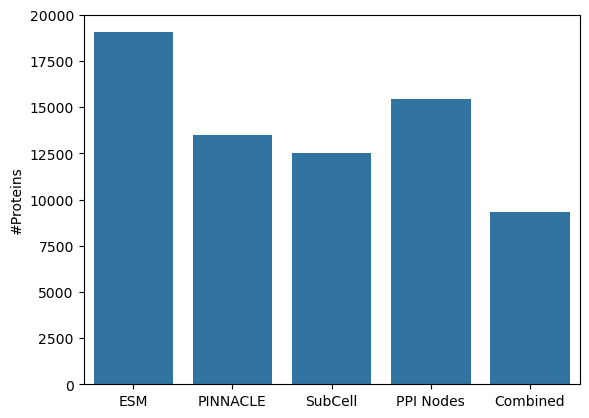

In [3]:

plot_dict = {
    'ESM': 19051,
    'PINNACLE': 13509,
    'SubCell': 12502,
    'PPI Nodes': 15461,
    'Combined': 9309,
}

sns.barplot(x=plot_dict.keys(), y=plot_dict.values())
plt.ylabel('#Proteins')
#plt.xlabel('Component')
plt.savefig('../figures/preprocessing/components_n.svg', dpi=400)

